In [1559]:
import geopandas as gpd
import folium
import geoplot as gplt

import shapely
from shapely.geometry import (
    Point,
    LineString,
    Polygon,
    MultiPoint,
    MultiLineString,
    MultiPolygon,
)

## Datos y mapas

Es importante tener en cuenta que si queremos juntar nuestra tabla con nuestro geojson, entonces debemos aplicar aplicar GeoDataFrame una vez unidos para que pueda ser leido por Folium.

```
df = data.merge(regiones, on="CUT_REG")
df = gpd.GeoDataFrame(df)
```

## Mapa

In [1560]:
import numpy as np

regiones = gpd.read_file(
    "https://raw.githubusercontent.com/SCantergiani/maps/main/REGIONES_2023.json"
)

regiones["SUPERFICIE_2"] = np.random.randint(0, 100, size=len(regiones))
regiones = gpd.GeoDataFrame(regiones)
regiones

,CUT_REG,REGION,SUPERFICIE,geometry,SUPERFICIE_2
0,04,Coquimbo,40587.80,"POLYGON ((-71.54229 -32.17702, -71.33889 -32.2...",55
1,16,Ñuble,13089.22,"POLYGON ((-72.88463 -36.44384, -72.79894 -36.6...",96
2,10,Los Lagos,48370.71,"MULTIPOLYGON (((-74.74387 -43.51682, -74.83232...",33
3,01,Tarapacá,42318.82,"POLYGON ((-70.05827 -21.43002, -69.66702 -21.4...",66
4,07,Maule,30311.18,"POLYGON ((-71.03594 -36.47488, -70.97429 -36.5...",99
5,15,Arica y Parinacota,16875.47,"POLYGON ((-70.28645 -19.22905, -69.94263 -19.0...",23
6,02,Antofagasta,126143.52,"POLYGON ((-70.65713 -26.06201, -70.60385 -26.0...",67
7,09,La Araucanía,31799.88,"POLYGON ((-71.67972 -39.56552, -71.61180 -39.6...",85
8,14,Los Ríos,18319.98,"POLYGON ((-71.87569 -40.56846, -71.84162 -40.4...",39
9,13,Metropolitana de Santiago,15398.38,"POLYGON ((-71.71548 -33.94893, -71.65960 -33.9...",65


In [1561]:
# Custom Tiles
attr = (
    '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
    'contributors, &copy; <a href="https://cartodb.com/attributions">CartoDB</a>'
)


tiles = "https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png"

In [1562]:
# Limites
min_lon, max_lon = -65, -90
min_lat, max_lat = -57, -10

#
mapita = folium.Map(
    location=[-33.458725289553634, -70.65252746454252],
    zoom_start=4.4,
    tiles=tiles,
    attr=attr,
    min_zoom=4,
    max_bounds=True,
    zoom_control=False,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
)

##Check limits
folium.CircleMarker([max_lat, min_lon], tooltip="Upper Left Corner").add_to(mapita)
folium.CircleMarker([min_lat, min_lon], tooltip="Lower Left Corner").add_to(mapita)
folium.CircleMarker([min_lat, max_lon], tooltip="Lower Right Corner").add_to(mapita)
folium.CircleMarker([max_lat, max_lon], tooltip="Upper Right Corner").add_to(mapita)

mapita

In [1563]:
# Podemos recortar el mapa
from branca.element import Figure

fig = Figure(width=520, height=680)
fig.add_child(mapita)

mapita

In [1564]:
# Agregando ColorMap

# df para mapear valores
eva_cols = ["CUT_REG", "SUPERFICIE", "SUPERFICIE_2"]  # id + Columnas a evaluar
color_dict = regiones[eva_cols].set_index("CUT_REG")


# funcion para crear paleta
def ColorMap(df, column: str):
    import branca.colormap as cm

    colormap = cm.linear.YlOrRd_04.scale(  # Podemos cambiar YlOrRd_04 por el color que queramos
        df[column].min(), df[column].max()
    )
    return colormap


colormap = ColorMap(regiones, "SUPERFICIE")
colormap.caption = "Superficie m2"
display(colormap)

# colormap.add_to(mapita)
# mapita

In [1565]:
# Funcionalidad mapa
layer = folium.GeoJson(
    data=regiones,  # es el dataframe consolidado (GeoDataFrame)
    name="regiones_1",
    zoom_on_click=False,  # Hace zoom o no al hacer click en un vector
    # Como queremos que se vean nuestros vectores
    style_function=lambda feature: {
        "color": "white",
        "weight": 1,
        "Opacity": 0.8,
        "fillOpacity": 0.8,
        "fillColor": colormap(
            color_dict["SUPERFICIE"][
                feature["properties"]["CUT_REG"]
            ]  # Superficie es el valor el cual se pinta el mapa
        ),
    },
    # Queremos agregar highligh en hover
    highlight_function=lambda x: {
        "fillColor": "#000000",
        "color": "#000000",
        "fillOpacity": 0.50,
        "weight": 0.1,
    },
    # Hover tooltip
    tooltip=folium.features.GeoJsonTooltip(
        fields=["CUT_REG", "REGION", "SUPERFICIE"],
        aliases=["CUT_REG", "REGION", "SUPERFICIE"],
        style=(
            "background-color: white; color: #333333; font-family: arial; font-size: 8px; padding: 10px;"
        ),
    ),
)

## Si queremos dejarlo como capa unica podemos usar este codigo
# layer.add_to(mapita)
# mapita

## Capas

In [1566]:
# Codigo para tener tener ColorMaps respectivos a la capa activa
from branca.element import MacroElement
from jinja2 import Template


class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """

    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(
            """
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """
        )  # noqa

In [1567]:
def ColorMapLayers(df, column: str):
    import branca

    colormap = branca.colormap.LinearColormap(
        ["y", "orange", "r"],
        vmin=df[column].min(),
        vmax=df[column].max(),
        caption=column,
    )

    return colormap

In [1568]:
import branca

cm1 = branca.colormap.LinearColormap(
    ["y", "orange", "r"],
    vmin=color_dict["SUPERFICIE"].min(),
    vmax=color_dict["SUPERFICIE"].max(),
    caption="cm1",
)

cm2 = branca.colormap.LinearColormap(
    ["b", "c", "g", "y", "r"],
    vmin=color_dict["SUPERFICIE_2"].min(),
    vmax=color_dict["SUPERFICIE_2"].max(),
    caption="cm2",
)
display(cm1, cm2)

In [1569]:
# Capa 1
layer_1 = folium.GeoJson(
    data=regiones,  # es el dataframe consolidado (GeoDataFrame)
    name="regiones_1",
    zoom_on_click=False,  # Hace zoom o no al hacer click en un vector,
    # Como queremos que se vean nuestros vectores
    style_function=lambda feature: {
        "color": "white",
        "weight": 1,
        "Opacity": 0.8,
        "fillColor": "orange",
        "fillOpacity": 0.8,
        "fillColor": cm1(color_dict["SUPERFICIE"][feature["properties"]["CUT_REG"]]),
    },
    # Queremos agregar highligh en hover
    highlight_function=lambda x: {
        "fillColor": "#000000",
        "color": "#000000",
        "fillOpacity": 0.50,
        "weight": 0.1,
    },
    # Hover tooltip
    tooltip=folium.features.GeoJsonTooltip(
        fields=["CUT_REG", "REGION", "SUPERFICIE"],
        aliases=["CUT_REG", "REGION", "SUPERFICIE"],
        style=(
            "background-color: white; color: #333333; font-family: arial; font-size: 8px; padding: 10px;"
        ),
    ),
)

# Capa 2
layer_2 = folium.GeoJson(
    data=regiones,  # es el dataframe consolidado (GeoDataFrame)
    name="regiones_2",
    zoom_on_click=False,  # Hace zoom o no al hacer click en un vector,
    # Como queremos que se vean nuestros vectores
    style_function=lambda feature: {
        "color": "white",
        "weight": 1,
        "Opacity": 0.8,
        "fillColor": "orange",
        "fillOpacity": 0.8,
        "fillColor": cm2(color_dict["SUPERFICIE_2"][feature["properties"]["CUT_REG"]]),
    },
    # Queremos agregar highligh en hover
    highlight_function=lambda x: {
        "fillColor": "#000000",
        "color": "#000000",
        "fillOpacity": 0.50,
        "weight": 0.1,
    },
    # Hover tooltip
    tooltip=folium.features.GeoJsonTooltip(
        fields=["CUT_REG", "REGION", "SUPERFICIE_2"],
        aliases=["CUT_REG", "REGION", "SUPERFICIE_2"],
        style=(
            "background-color: white; color: #333333; font-family: arial; font-size: 8px; padding: 10px;"
        ),
    ),
)

In [1570]:
from folium.plugins import GroupedLayerControl

fg1 = folium.FeatureGroup("superficie_1")
layer_1.add_to(fg1)
mapita.add_child(fg1)
mapita.add_child(cm1)
mapita.add_child(BindColormap(fg1, cm1))

fg2 = folium.FeatureGroup("superficie_2")
layer_2.add_to(fg2)
mapita.add_child(fg2)
mapita.add_child(cm2)
mapita.add_child(BindColormap(fg2, cm2))

GroupedLayerControl(
    groups={"Groups": [fg1, fg2]},
    collapsed=True,
).add_to(mapita)
mapita

In [1571]:
# Capa 1
mapita = folium.Map(
    location=[-33.458725289553634, -70.65252746454252], zoom_start=4.4, tiles=None
)
# fig = Figure(width=520, height=680)
# fig.add_child(mapita)

fig_layer = []
layers = []
colormaps = []

for i, col in enumerate(color_dict.columns):
    cm = ColorMapLayers(color_dict, col)
    layer = folium.GeoJson(
        data=regiones,  # es el dataframe consolidado (GeoDataFrame)
        name=f"regiones_{col}",
        overlay=False,
        zoom_on_click=False,  # Hace zoom o no al hacer click en un vector,
        # Como queremos que se vean nuestros vectores
        style_function=lambda feature: {
            "color": "white",
            "weight": 1,
            "Opacity": 0.8,
            "fillColor": "orange",
            "fillOpacity": 0.8,
            "fillColor": cm(color_dict[col][feature["properties"]["CUT_REG"]]),
        },
        # Queremos agregar highligh en hover
        highlight_function=lambda x: {
            "fillColor": "#000000",
            "color": "#000000",
            "fillOpacity": 0.50,
            "weight": 0.1,
        },
        # Hover tooltip
        tooltip=folium.features.GeoJsonTooltip(
            fields=["CUT_REG", "REGION", col],
            aliases=["CUT_REG", "REGION", col],
            style=(
                "background-color: white; color: #333333; font-family: arial; font-size: 8px; padding: 10px;"
            ),
        ),
    )

    fg = folium.FeatureGroup(col.lower())
    layer.add_to(fg)

    fig_layer.append(fg)
    colormaps.append(cm)


for fg, cm in zip(fig_layer, colormaps):
    mapita.add_child(fg)
    mapita.add_child(cm)
    mapita.add_child(BindColormap(fg, cm))

GroupedLayerControl(
    groups={"Groups": fig_layer},
    collapsed=False,
).add_to(mapita)

mapita

In [1572]:
mapita = folium.Map(
    location=[-33.458725289553634, -70.65252746454252],
    zoom_start=4.4,
    tiles=tiles,
    attr=attr,
)
folium.Choropleth(
    geo_data=regiones,
    name="regiones",
    data=regiones,
    columns=["CUT_REG", "SUPERFICIE"],
    key_on="feature.properties.CUT_REG",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Superficie",
).add_to(mapita)

folium.LayerControl().add_to(mapita)
mapita

## Mapas estaticos

In [1573]:
## Correr si hay error multipologonos
regiones = regiones.apply(
    lambda x: list(x) if isinstance(x, MultiPolygon) else x
).explode(index_parts=True)

c:\Users\Seb\AppData\Local\Programs\Python\Python311\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 6.
  self.bins = quantile(y, k=k)


Text(0.5, 1.0, 'Unemployment rate in US counties')

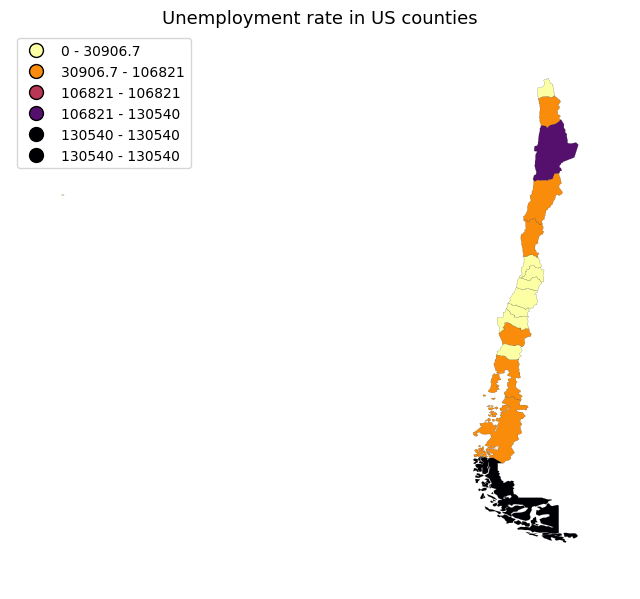

In [1574]:
# Para esta libreria la columna id debe ser numerica
regiones.CUT_REG = regiones.CUT_REG.astype(int)

# Initialize the figure
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 12))

# Set up the color sheme:
import mapclassify as mc

scheme = mc.Quantiles(regiones["SUPERFICIE"], k=10)

# Map
gplt.choropleth(
    regiones,
    hue="SUPERFICIE",
    linewidth=0.1,
    scheme=scheme,
    cmap="inferno_r",
    legend=True,
    edgecolor="black",
    ax=ax,
)

ax.set_title("Unemployment rate in US counties", fontsize=13)